# Backpropagation and Multilayer Neural Networks

### Goals: 
- Intro: train a neural network with high level framework `Keras`
- Diving deep: implement a real gradient descent in `Numpy`
- Auto-differentiation: the basics of `TensorFlow`

### Dataset:
- Digits: 10 class handwritten digits
- http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

In [1]:
%matplotlib inline 
# display figures in the notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

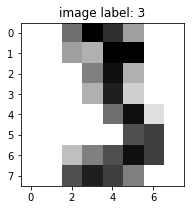

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- normalization
- train/test split

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)

Let's display the one of the transformed sample (after feature standardization):

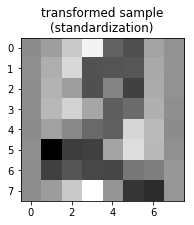

In [4]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(X_train[sample_index].reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("transformed sample\n(standardization)");

The scaler objects makes it possible to recover the original sample:

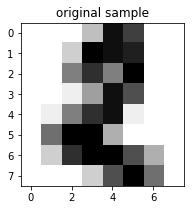

In [5]:
plt.figure(figsize=(3, 3))
plt.imshow(scaler.inverse_transform(X_train[sample_index]).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("original sample");

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1527, 64) (1527,)
(270, 64) (270,)


# TensorFlow Implementation

TensorFlow is a symbolic graph computation engine, that allows automatic differentiation of each node
- https://www.tensorflow.org 
- https://www.tensorflow.org/tutorials/mnist/tf/

TensorFlow builds where nodes may be:
- **constant:** constants tensors, such as a learning rate
- **Variables:** any tensor, such as parameters of the models
- **Placeholders:** placeholders for inputs and outputs of your models
- many other types of nodes (functions, loss, ...)

The graph is symbolic, no computation is performed until a `Session` is defined and the command `run` or `eval` is invoked. TensorFlow may run this computation on (multiple) CPUs or GPUs

In [7]:
import tensorflow as tf

a = tf.constant(3)
b = tf.constant(2)
c = tf.Variable(0)
c = a + b
with tf.Session() as sess:
    print(sess.run(c))

5


In [8]:
X = tf.placeholder("float32", name="input")
Y = X + tf.constant(3.0)
with tf.Session() as sess:
    print(sess.run(Y, feed_dict={X:2}))

5.0


**Note: batches in inputs**
- the first dimension of the input is usually kept for the batch dimension. A typical way to define an input placeholder with a 1D tensor of 128 dimensions, is:
```
X = tf.placeholder("float32", shape=[None, 128])
```

## a) Build a model using TensorFlow

- Using TensorFlow, build a similar model (one hidden layer) as you previously did
- the input will be a batch coming from X_train, and the output will be a batch of ints

In [9]:
# helper functions

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))


def accuracy(y_pred, y=y_test):
    return np.mean(np.argmax(y_pred, axis=1) == y)

In [45]:
# hyperparams
batch_size = 32
hidden_size = 1000
learning_rate = 0.01
num_epochs = 50
input_size = X_train.shape[1]
output_size = 10

# input and output
X = tf.placeholder("float32", shape=[None, input_size])
y = tf.placeholder("int32", shape=[None])

#todo: build the model and weights (use init_weights)

W_h = init_weights([input_size, hidden_size])
b_h = init_weights([hidden_size])
W_o = init_weights([hidden_size, output_size])
b_o = init_weights([output_size])
h = tf.nn.sigmoid(tf.matmul(X,W_h) + b_h)
out_act = tf.matmul(h,W_o) + b_o

#todo: build the loss, predict, and train operator
# Use reduce_sum for the loss
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = out_act, labels = y)
loss = tf.reduce_sum(cross_entropy)

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

#todo: build predict node
predict = tf.nn.softmax(out_act)

# Initialization of all variables in the graph
init = tf.global_variables_initializer()

epoch: 0 train accuracy: 0.210 test accuracy: 0.159
epoch: 1 train accuracy: 0.744 test accuracy: 0.726
epoch: 2 train accuracy: 0.798 test accuracy: 0.837
epoch: 3 train accuracy: 0.879 test accuracy: 0.867
epoch: 4 train accuracy: 0.948 test accuracy: 0.930
epoch: 5 train accuracy: 0.959 test accuracy: 0.933
epoch: 6 train accuracy: 0.965 test accuracy: 0.926
epoch: 7 train accuracy: 0.966 test accuracy: 0.937
epoch: 8 train accuracy: 0.968 test accuracy: 0.937
epoch: 9 train accuracy: 0.970 test accuracy: 0.944
epoch: 10 train accuracy: 0.972 test accuracy: 0.948
epoch: 11 train accuracy: 0.978 test accuracy: 0.952
epoch: 12 train accuracy: 0.980 test accuracy: 0.952
epoch: 13 train accuracy: 0.982 test accuracy: 0.952
epoch: 14 train accuracy: 0.983 test accuracy: 0.948
epoch: 15 train accuracy: 0.984 test accuracy: 0.959
epoch: 16 train accuracy: 0.985 test accuracy: 0.959
epoch: 17 train accuracy: 0.986 test accuracy: 0.959
epoch: 18 train accuracy: 0.986 test accuracy: 0.959
epo

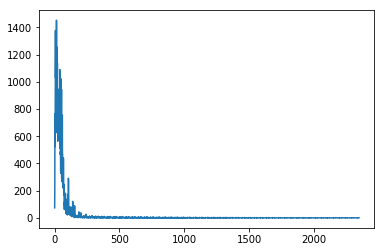

In [46]:
# run training
with tf.Session() as sess: 
    sess.run(init)
    
    losses = []
    for e in range(num_epochs):
        for i in range(X_train.shape[0] // batch_size):
            # Build batches of batch_size            
            idx, idxn = i * batch_size, min(X_train.shape[0]-1, (i+1) * batch_size)
            batch_xs, batch_ys = X_train[idx: idxn], y_train[idx: idxn]            
            
            # Run train operator and monitor loss
            _, l=sess.run([train_op, loss], feed_dict={X: batch_xs, y: batch_ys})
            losses.append(l)
        
        # For each epoch, run accuracy on train and test
        predicts_test = sess.run(predict, feed_dict={X: X_test})
        predicts_train = sess.run(predict, feed_dict={X: X_train})
        print("epoch: %d train accuracy: %0.3f test accuracy: %0.3f"
              % (e, accuracy(predicts_train, y_train), accuracy(predicts_test)))
    
    # For monitoring purposes
    file_writer = tf.summary.FileWriter('./tensorflow_summaries', sess.graph)    
plt.plot(losses);

## b) Exercises

### Bonus:
- add L2 regularization with $\lambda = 10^{-4}$
- train with arbitrary number of layers by only defining layer sizes
- follow the official tensorflow tutorial: https://www.tensorflow.org/tutorials/mnist/tf/